# Nenadzirano učenje

Nenadzirano učenje je vrsta strojnog učenja gdje je cilj istražiti strukturu dostupnih podataka kako bi izvukli važne informacije (npr. otkriti nekakva interesantna svojstva). Pri tome je raspoloživi skup podataka neoznačen (znači nećemo imati vrijednosti odgovarajuće izlazne veličine) i ne postoji sustav nagrađivanja tijekom učenja kao kod podržanog učenja.

Dva česta problema u nenadziranom učenju su grupiranje podataka i smanjivanje dimenzionalnosti i rekonstrukcija. U ovoj laboratorijskoj vježbi ćemo se baviti drugim problemom, smanjivanjem dimenzionalnosti i rekonstrukcijom. Za ovo ćemo koristiti autoenkodere.

## Autoenkoderi

Autoenkoderi su vrsta neuronskih mreža koje se koriste za učenje efikasnih reprezentacija podataka, a imaju široku primjenu u područjima poput kompresije podataka, generiranja slika i detekcije anomalija.

Autoenkoderi se sastoje od dvije osnovne komponente - enkodera i dekodera. Enkoder prima ulazni primjer i preslikava ga u kompaktni vektor (vektor niže dimenzije od ulaznog primjera). Dekoder zatim koristi taj vektor kako bi rekonstruirao originalni ulaz.

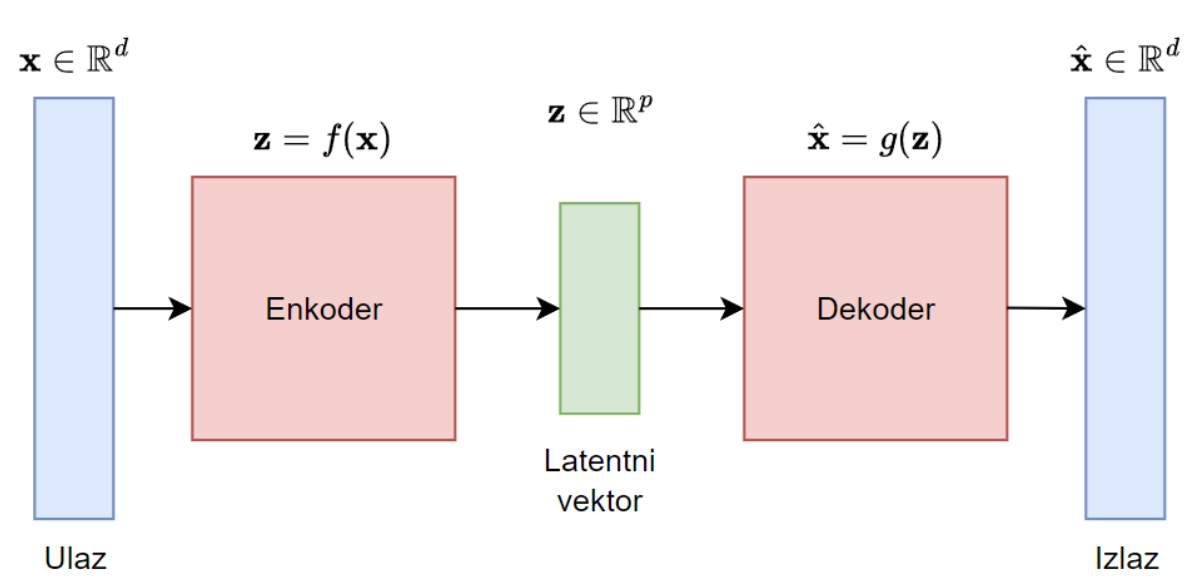

### Konvolucijski autoenkoder

Konvolucijski autoenkoderi koriste operacije konvolucije i [transponirane konvolucije](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). Umjesto transponirane konvolucije se također koristi i kombinacija *upsampling* i konvolucijskih slojeva u dekoderu. U enkoderu je cilj smanjiti dimenzionalnost. Ovo se može postići na dva načina:
 - Korištenjem slojeva sažimanja za smanjenje dimenzionalnosti nakon konvolucijskih slojeva
 - Korištenjem *stridea* većeg od 1 u konvolucijskim slojevima, čime se također smanje dimenzije izlaznih matrica


 Postoje dva česta pristupa rekonstrukciji slike u dekoderu:
  - Korištenjem tzv. *upsampling* slojeva popraćenih standardnim konvolucijskim slojevima
  - Korištenjem transponirante konvolucije za povećanje dimenzionalnosti

  
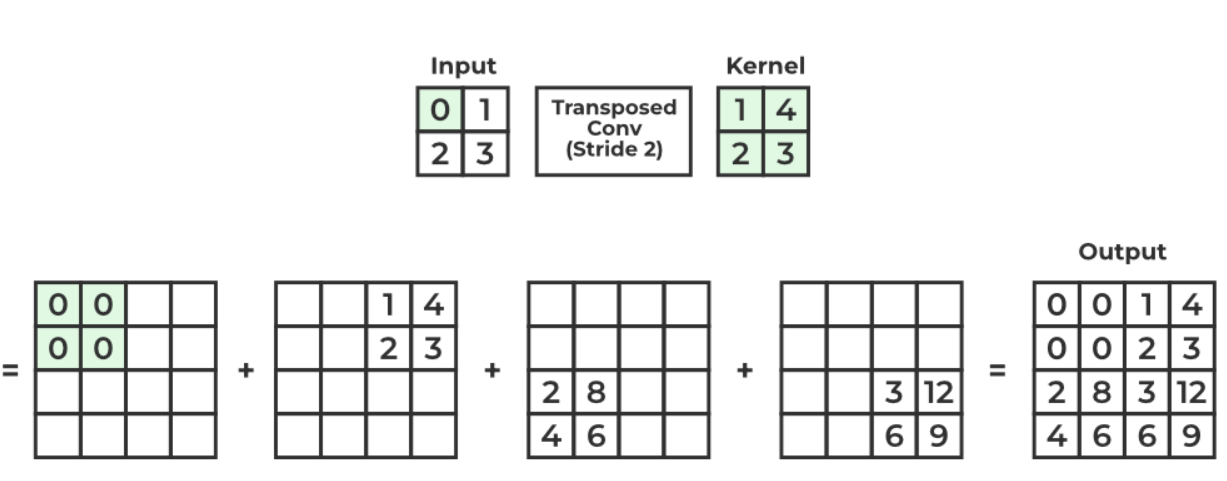

Dimenzije izlazne matrice iz konvolucije:
$$n_{out} = \left\lfloor\frac{n_{in} + 2p - k}{s}\right\rfloor + 1$$

Dimenzije izlazne matrice kod transponirane konvolucije:
$$n_{out} = s(n_{in} - 1) + k - 2p$$

Gdje su:
 - $n_{out}$ - dimenzija izlazne matrice
 - $n_{in}$ - dimenzija ulazne matrice
 - $k$ - dimenzija kernela
 - $s$ - *stride*
 - $p$ - *padding*

## Zadaci

1. Izradite konvolucijski autoenkoder sa sheme te ga istrenirajte na podatkovnom skupu [MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html). Koristite BCELoss za funkciju gubitka. Brojevi na shemi prikazuju dimenzije izlazne matrice iz svakog pojedinog sloja, prvi broj predstavlja broj kanala. Istestirajte vaš autoenkoder i prikažite primjere parova ulaznih i izlanih slika.

2. Prilikom treniranja i testiranja dodajte normalan (Gaussov) šum na ulazne slike iz MNIST podatkovnog skupa. Vaš autoenkoder treba rekonstruirati slike bez dodanog šuma. Po potrebi prilagodite strukturu mreže. Isprobajte razne parametre šuma.

3. Izradite proizvoljan autoenkoder te ga istrenirajte na podatkovnom skupu [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). Upute za dohvaćanje podatkovnog skupa dane su u nastavku. Također je potrebno izraditi vlastitu *dataset* klasu za dani podatkovni skup.

Dodatno:

Zacrnite nasumične pravokutnike na ulaznim slikama iz 3. zadatka te istrenirajte autoenkoder za uklanjanje pravokutnika. Isprobajte s različitim veličinama pravokutnika.

#### Shema mreže za prvi zadatak.

Plavom bojom su prikazani izlazi iz pojedinih slojeva enkodera, narančastom bojom su prikazani izlazi iz pojedinih slojeva dekodera. *Kernel size* i *stride* za sve slojeve trebaju biti 4 i 2. *Padding* prilagodite ovisno o željenoj veličini izlaza. Svi konvolucijski slojevi popraćeni su ReLU aktivacijskom funkcijom osim posljednjeg sloja u dekoderu, on je popraćen sigmoid aktivacijskom funkcijom kako bi se dobio izlaz između 0 i 1, odnosno u istom formatu kao što su ulazne slike. Alternativno možete koristiti kombinaciju [*upsampling*](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html) i konvolucijskih slojeva u dekoderu.


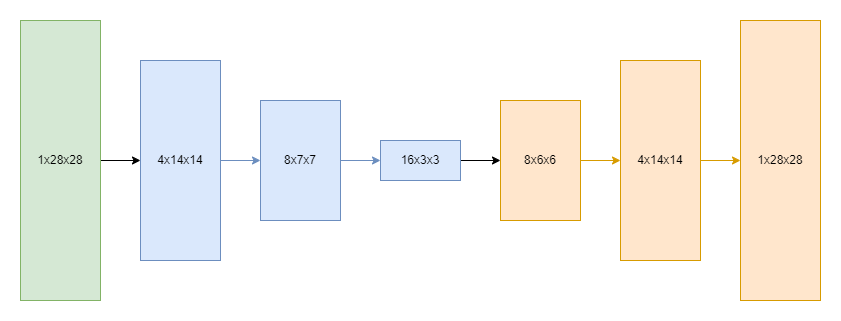

In [ ]:
#Generiranje izlaza iz latentnog vektora

#Uklanjanje šuma
#Smanjenje dimenzionalnosti
#Treniranje feature extractora

#16 8 4 4 0

In [27]:
## Importing useful libraries
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary

import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [26]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)  # 14x14 -> 7x7
        self.fc1 = nn.Linear(7 * 7 * 64, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc2 = nn.Linear(128, 7 * 7 * 64)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
    def forward(self, x):
        x = self.fc2(x)
        x = x.view(x.size(0), 64, 7, 7)
        x = self.deconv1(x)
        x = torch.relu(x)
        x = self.deconv2(x)
        return torch.sigmoid(x)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

if __name__ == "__main__":
    model = Autoencoder()

    input_data = torch.randn(8, 1, 28, 28)

    output_data = model(input_data)
    print(output_data.shape)

torch.Size([8, 1, 28, 28])


In [8]:
model = Autoencoder()
model.to(device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc2): Linear(in_features=128, out_features=3136, bias=True)
    (deconv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [9]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
            Conv2d-2             [-1, 64, 7, 7]          18,496
            Linear-3                  [-1, 128]         401,536
           Encoder-4                  [-1, 128]               0
            Linear-5                 [-1, 3136]         404,544
   ConvTranspose2d-6           [-1, 32, 14, 14]          18,464
   ConvTranspose2d-7            [-1, 1, 28, 28]             289
           Decoder-8            [-1, 1, 28, 28]               0
Total params: 843,649
Trainable params: 843,649
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 3.22
Estimated Total Size (MB): 3.38
----------------------------------------------------------------


In [10]:
def visualize(model, dataloader, noise_function, noise_param, n=4):
  fig, ax = plt.subplots(n, 2)

  for i in range(n):
    img = noise_function(next(iter(dataloader))[0][i], noise_param)
    img_ = img.numpy().transpose(1, 2, 0)
    ax[i, 0].imshow(img_)
    img = img.to(device)
    recon = model(img)
    recon_ = recon.detach().cpu().numpy().transpose(1, 2, 0)
    ax[i, 1].imshow(recon_)
  plt.show()

U nastavku slijede upute za rad s CelebA podatkovnog skupa. Pratite prva dva koraka prikazana [ovdje](https://www.kaggle.com/discussions/general/74235). Nakon toga `kaggle.json` datoteku stavite na svoj Google Drive. Preporučeno je staviti datoteku u root direktorij Google Drivea, ali možete ga staviti i na drugu lokaciju, ali onda trebate prilagoditi putanju u naredbi `! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/`.

Ukoliko primijetite da vam izlazne slike imaju rešetke (*grid*) ili su nalik na šahovnicu, pokušajte izraditi autoenkoder pomoću *pooling* i *upsampling* slojeva, bez korištenja transponiranih konvolucija. Više o ovom problemu, pročitajte [ovdje](https://distill.pub/2016/deconv-checkerboard/).

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 433, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [16]:
! kaggle datasets download jessicali9530/celeba-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [17]:
%%capture
! unzip celeba-dataset.zip -d /content/celeba

In [22]:
dataset_path = '/content/celeba/img_align_celeba/img_align_celeba'
batch_size = 128

In [23]:
from torchvision.io import read_image
import os

class CustomImageDataset(data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.images[idx])
        image = read_image(image_path)
        if self.transform:
            image = self.transform(image)
        return image

In [24]:
def convert_image_dtype(image):
  return transforms.functional.convert_image_dtype(image)

In [41]:
img_transform = transforms.Compose([
    transforms.functional.convert_image_dtype,
    transforms.Resize((192, 192), antialias=True)
])

train_data = CustomImageDataset(dataset_path, img_transform)
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=2)

FileNotFoundError: [Errno 2] No such file or directory: '/content/celeba/img_align_celeba'

In [46]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 3×28×28 → 4×14×14 → 8×7×7 → 16×3×3
        self.conv1 = nn.Conv2d(3,  4, kernel_size=4, stride=2, padding=1)  # 28→14
        self.conv2 = nn.Conv2d(4,  8, kernel_size=4, stride=2, padding=1)  # 14→7
        self.conv3 = nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1)  # 7→3
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))  # → (4,14,14)
        x = self.relu(self.conv2(x))  # → (8,7,7)
        x = self.relu(self.conv3(x))  # → (16,3,3)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 16×3×3 → 8×6×6 → 4×14×14 → 3×28×28
        self.tconv1  = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)  # 3→6
        self.tconv2  = nn.ConvTranspose2d(8,  4, kernel_size=4, stride=2, padding=0)  # 6→14
        self.tconv3  = nn.ConvTranspose2d(4,  3, kernel_size=4, stride=2, padding=1)  # 14→28
        self.relu    = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.tconv1(x))   # → (8,6,6)
        x = self.relu(self.tconv2(x))   # → (4,14,14)
        x = self.sigmoid(self.tconv3(x))# → (3,28,28), outputs in [0,1]
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [47]:
def add_gaussian_noise(img, sigma):
    noisy = img + sigma * torch.randn_like(img)
    return torch.clamp(noisy, 0., 1.)

In [48]:
def train_autoencoder(loader, denoise=False, noise_sigma=0.1):
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        desc = f"Epoch {epoch}/{num_epochs} [{'Denoising' if denoise else 'Basic'} AE]"
        for images in tqdm(loader, desc=desc):
            images = images.to(device, non_blocking=True)
            inputs = add_gaussian_noise(images, noise_sigma) if denoise else images

            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss    = criterion(outputs, images)
            running_loss += loss.item() * images.size(0)
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / len(loader.dataset)
        print(f"{desc} Loss: {epoch_loss:.4f}")

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
batch_size = 32

In [52]:
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
from torchvision.datasets import MNIST
from torchsummary import summary

import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm

In [53]:
mnist_train = MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

class MNISTRGBDataset(data.Dataset):
    def __init__(self, mnist_dataset):
        self.dataset = mnist_dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        img, _ = self.dataset[idx]          # img: [1,28,28]
        img_rgb = img.repeat(3, 1, 1)      # → [3,28,28]
        return img_rgb

train_data = MNISTRGBDataset(mnist_train)
train_loader = data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [54]:
train_autoencoder(train_loader, denoise=False)

Epoch 1/10 [Basic AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/10 [Basic AE] Loss: 0.1528


Epoch 2/10 [Basic AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/10 [Basic AE] Loss: 0.0838


Epoch 3/10 [Basic AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/10 [Basic AE] Loss: 0.0784


Epoch 4/10 [Basic AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/10 [Basic AE] Loss: 0.0761


Epoch 5/10 [Basic AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/10 [Basic AE] Loss: 0.0747


Epoch 6/10 [Basic AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6/10 [Basic AE] Loss: 0.0738


Epoch 7/10 [Basic AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7/10 [Basic AE] Loss: 0.0731


Epoch 8/10 [Basic AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8/10 [Basic AE] Loss: 0.0727


Epoch 9/10 [Basic AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9/10 [Basic AE] Loss: 0.0723


Epoch 10/10 [Basic AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10/10 [Basic AE] Loss: 0.0720


In [55]:
def visualize_mnist(model, dataloader, noise_function=None, noise_param=None, n=4):
    """
    Show n examples of (noisy) input → reconstruction on MNIST.
    Automatically handles 1- or 3-channel tensors.
    """
    model.eval()
    fig, axes = plt.subplots(n, 2, figsize=(5, 2 * n))
    it = iter(dataloader)

    with torch.no_grad():
        for i in range(n):
            batch = next(it)
            imgs = batch[0] if isinstance(batch, (list, tuple)) else batch

            img = imgs[i].to(device)  # [1,28,28] or [3,28,28]

            # noise
            noisy = noise_function(img, noise_param) if noise_function else img

            # reconstruction
            recon = model(noisy.unsqueeze(0)).squeeze(0)

            # to numpy
            noisy_np = noisy.cpu().numpy()
            recon_np = recon.cpu().numpy()

            # channel-first → channel-last if needed
            if noisy_np.ndim == 3:
                noisy_np = noisy_np.transpose(1, 2, 0)
            if recon_np.ndim == 3:
                recon_np = recon_np.transpose(1, 2, 0)

            # plot input
            ax_in, ax_out = axes[i]
            if noisy_np.ndim == 2:  # grayscale
                ax_in.imshow(noisy_np, cmap='gray')
            else:                  # RGB
                ax_in.imshow(noisy_np)
            ax_in.set_title('Input')
            ax_in.axis('off')

            # plot reconstruction
            if recon_np.ndim == 2:
                ax_out.imshow(recon_np, cmap='gray')
            else:
                ax_out.imshow(recon_np)
            ax_out.set_title('Reconstruction')
            ax_out.axis('off')

    plt.tight_layout()
    plt.show()


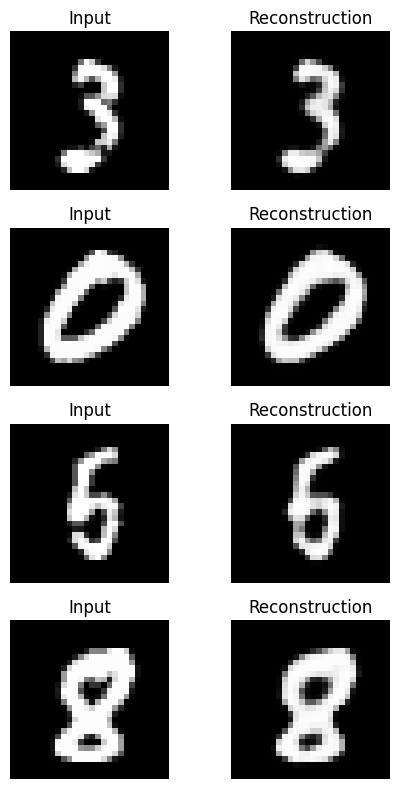

In [56]:
visualize_mnist(model, train_loader, noise_function=None, n=4)

In [57]:
train_autoencoder(train_loader, denoise=True, noise_sigma=0.1)

Epoch 1/10 [Denoising AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/10 [Denoising AE] Loss: 0.0728


Epoch 2/10 [Denoising AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/10 [Denoising AE] Loss: 0.0724


Epoch 3/10 [Denoising AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/10 [Denoising AE] Loss: 0.0722


Epoch 4/10 [Denoising AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/10 [Denoising AE] Loss: 0.0720


Epoch 5/10 [Denoising AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/10 [Denoising AE] Loss: 0.0718


Epoch 6/10 [Denoising AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6/10 [Denoising AE] Loss: 0.0717


Epoch 7/10 [Denoising AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7/10 [Denoising AE] Loss: 0.0715


Epoch 8/10 [Denoising AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8/10 [Denoising AE] Loss: 0.0714


Epoch 9/10 [Denoising AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9/10 [Denoising AE] Loss: 0.0713


Epoch 10/10 [Denoising AE]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10/10 [Denoising AE] Loss: 0.0712


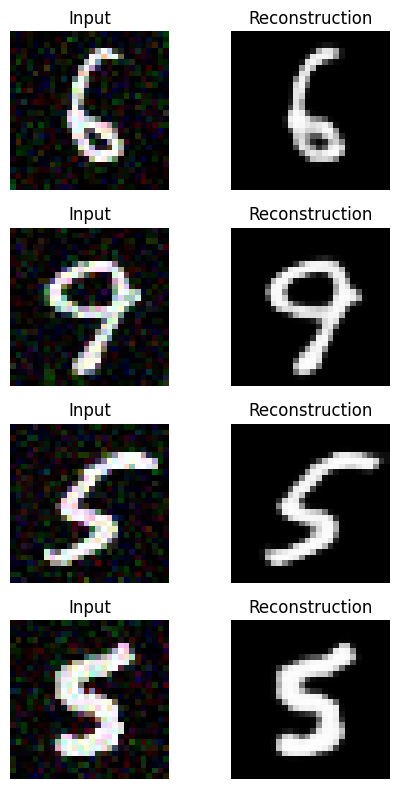

In [58]:
visualize_mnist(model, train_loader, noise_function=add_gaussian_noise, noise_param=0.1, n=4)


=== Noise σ = 0.05 ===


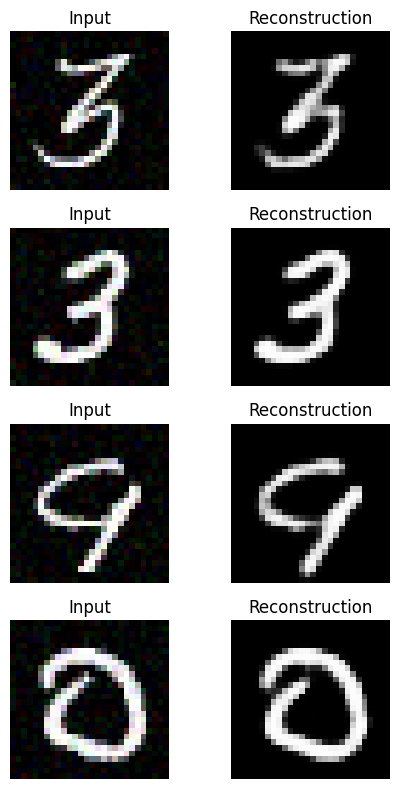


=== Noise σ = 0.1 ===


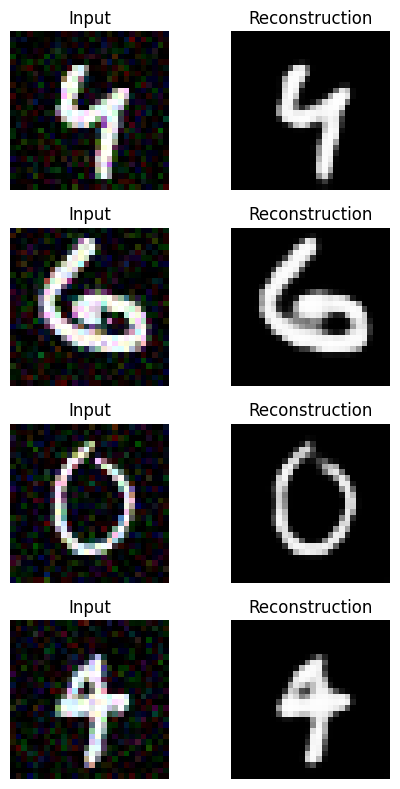


=== Noise σ = 0.2 ===


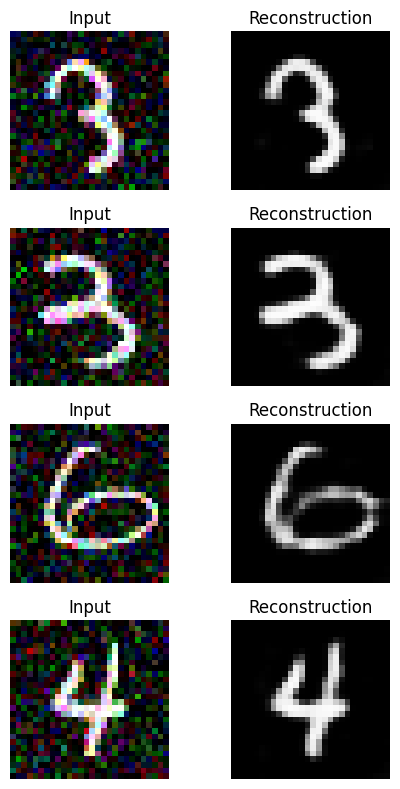

In [59]:
for sigma in [0.05, 0.1, 0.2]:
    print(f"\n=== Noise σ = {sigma} ===")
    visualize_mnist(model, train_loader, noise_function=add_gaussian_noise, noise_param=sigma, n=4)

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.BCELoss()  # use raw logits from decoder  # outputs are in [0,1]
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
scaler = torch.amp.GradScaler() if device.type=='cuda' else None

In [61]:
def visualize(model, dataloader, noise_function, noise_param, n=4):
  fig, ax = plt.subplots(n, 2)

  for i in range(n):
    img = noise_function(next(iter(dataloader))[0][i], noise_param)
    img_ = img.numpy().transpose(1, 2, 0)
    ax[i, 0].imshow(img_)
    img = img.to(device)
    recon = model(img)
    recon_ = recon.detach().cpu().numpy().transpose(1, 2, 0)
    ax[i, 1].imshow(recon_)
  plt.show()

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 433, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
